In [552]:
!pip install catboost -q

In [669]:
# Import the libraries

import sys
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from pandas.plotting import scatter_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use("ggplot")

np.random.seed(0)

In [612]:
# Load the data

train = pd.read_csv("./OneDrive/Documents/Ames+Regression/train.csv", index_col = "Id")
test = pd.read_csv("./OneDrive/Documents/Ames+Regression/test.csv", index_col = "Id")

price = train.SalePrice   
train.drop("SalePrice", axis = 1, inplace = True)

In [613]:
# Quick glance over data shows some missing values
train.sample(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Alloca
492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,1Fam,1.5Fin,6,7,1941,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,403,Rec,165,238,806,GasA,TA,Y,FuseA,958,620,0,1578,1,0,1,0,3,1,Fa,5,Typ,2,TA,Attchd,1941.0,Unf,1,240,TA,TA,Y,0,0,32,0,0,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal
460,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,5,4,1950,1950,Gable,CompShg,MetalSd,MetalSd,BrkCmn,161.0,TA,TA,CBlock,TA,TA,No,LwQ,185,Unf,0,524,709,GasA,TA,Y,SBrkr,979,224,0,1203,1,0,1,0,3,1,Gd,5,Typ,1,TA,Detchd,1950.0,Unf,1,352,TA,TA,Y,0,0,248,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,2Story,7,5,1977,1977,Hip,CompShg,Plywood,Plywood,BrkFace,299.0,TA,TA,CBlock,Gd,TA,No,BLQ,392,Unf,0,768,1160,GasA,Ex,Y,SBrkr,1156,866,0,2022,0,0,2,1,4,1,TA,8,Typ,1,TA,Attchd,1977.0,Fin,2,505,TA,TA,Y,288,117,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal
656,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1971,1971,Gable,CompShg,HdBoard,ImStucc,BrkFace,381.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,525,525,GasA,TA,Y,SBrkr,525,567,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1971.0,Unf,1,264,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Family
1014,30,RM,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,4,1910,2006,Hip,CompShg,MetalSd,Stucco,None,0.0,TA,TA,BrkTil,TA,TA,No,ALQ,247,Rec,465,310,1022,GasW,TA,N,SBrkr,1022,0,0,1022,1,0,1,0,2,1,TA,4,Maj2,0,NaN,Detchd,1956.0,Unf,1,280,TA,TA,Y,0,30,226,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
1404,20,RL,49.0,15256,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Somerst,RRAn,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,Stone,84.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,929,Unf,0,556,1485,GasA,Ex,Y,SBrkr,1464,0,0,1464,1,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Unf,3,754,TA,TA,Y,168,160,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
602,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,6,6,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,PConc,TA,TA,No,Unf,0,Unf,0,780,780,GasA,TA,Y,SBrkr,780,595,0,1375,0,0,1,1,3,1,Gd,6,Typ,1,Gd,Detchd,1979.0,Unf,1,544,TA,TA,P,0,162,0,0,126,0,NaN,NaN,NaN,0,12,2007,WD,Normal
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml


In [614]:
print(f"Shape of the TRAIN set {train.shape}")
print(f"Shape of the TEST set {test.shape}")

Shape of the TRAIN set (1460, 79)
Shape of the TEST set (1459, 79)


### Exploratory Data Analysis

In [615]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


There are a few noteworthy statistics here. 
1. Lot area ranges between 1300 SF up to slightly higher than 215000 SF with a mean of 10517 SF.
2. The houses were built from 1872 to 2010.
3. The mean sale price is 180,921 USD while the median is 163,000 USD. 

Let's look further into the distribution of prices. 

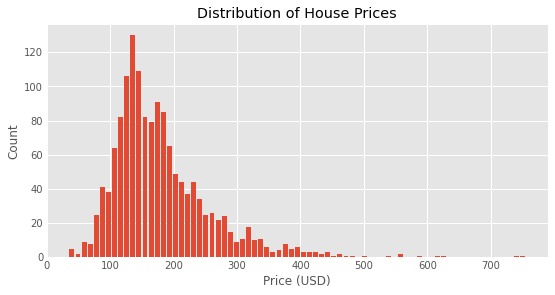

In [616]:
# What's the price range?

(train1.SalePrice/1000).hist(bins=75, rwidth=.8, figsize=(8,4))
plt.title('Distribution of House Prices')
plt.ylabel("Count")
plt.xlabel("Price (USD)")
plt.show()

Prices are apparantly skewed to the right. I will consider a log transformation to make them more Gaussian
The plot above and the barplot below suggest the existence of some outliers. 

Median: 163000.0


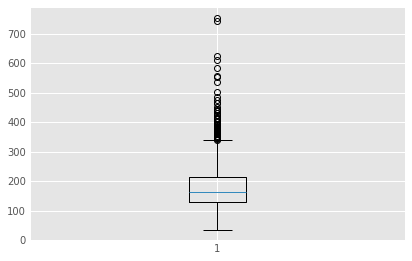

In [617]:
plt.boxplot(price/1000);
print("Median: {}".format(train1["SalePrice"].median()))

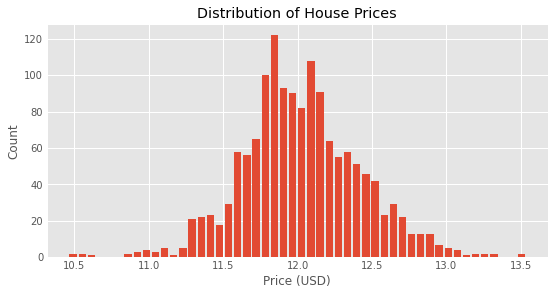

In [618]:
# Are log prices more Gaussian?

(np.log(train1.SalePrice)).hist(bins=50, rwidth=.8, figsize=(8,4))
plt.title('Distribution of House Prices')
plt.ylabel("Count")
plt.xlabel("Price (USD)")
plt.show()

The next question is "what are the most correlated features with the response variable?"

Based on the numbers below, it seems that overall quality and the living area above ground are very important. Some of the features can be combined in the top 10. For instance GarageCars and GarageArea are probably signaling the 
same thing. 

In [619]:
corr_with_price = train.corrwith(price).sort_values(ascending=False)
corr_with_price.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
dtype: float64

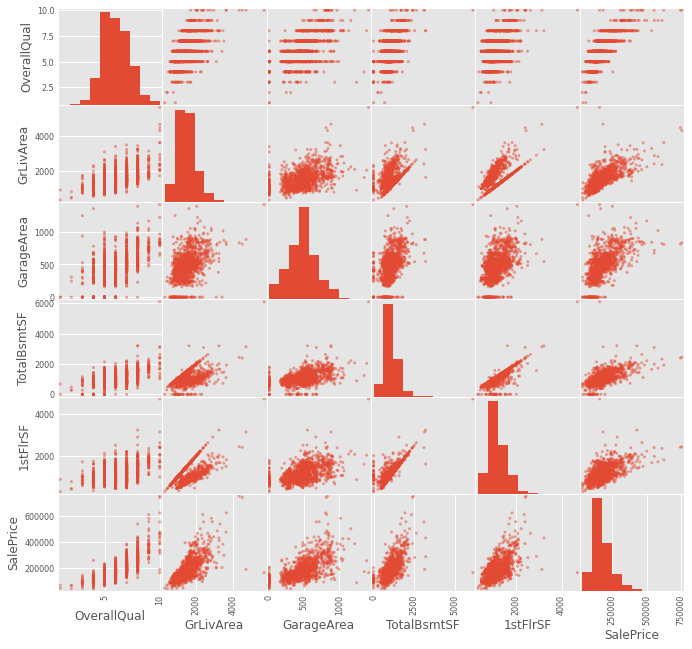

In [620]:
#Let's take a quick look at some of the features and how they are related to price. 

top_features = ["OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF",'SalePrice']

scatter_matrix(train1[top_features], figsize=(10,10));

The year the house was built


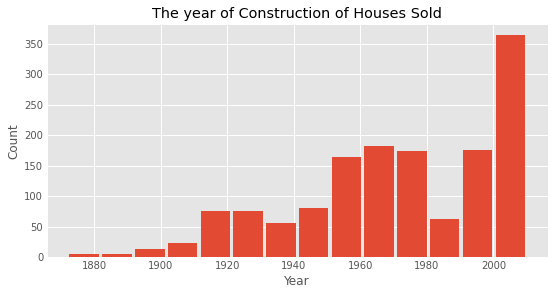

In [571]:
# When were the houses built?
print('The year the house was built'.format(
    train1.YearBuilt.min(), train1.YearBuilt.max()))
train1.YearBuilt.hist(bins=14, rwidth=.9, figsize=(8,4))
plt.title('The year of Construction of Houses Sold')
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()

Looks like most houses the rate of construction has increased dramatticaly after 2000. 

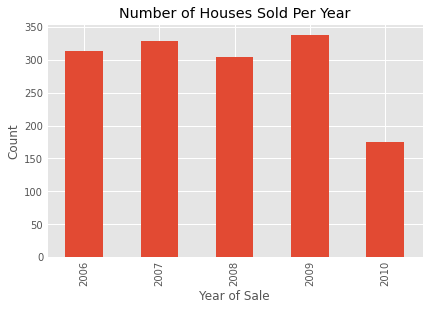

In [572]:
# When where houses sold?
train1.groupby(['YrSold']).SalePrice.count().plot(kind='bar', figsize=(6,4))
plt.title('Number of Houses Sold Per Year')
plt.ylabel("Count")
plt.xlabel("Year of Sale")
plt.show()

The above charts reveal certain surprises. In 2010, the number of houses sold dropped to less than half of the number in 2009. Otherwise, all the other years have a fairly similar number of houses sold. This could be due to the foreclosure crisis in 2010 when people put off selling their houses due to houses being forclosured in ther neighborhood leading to a reduction in prices.

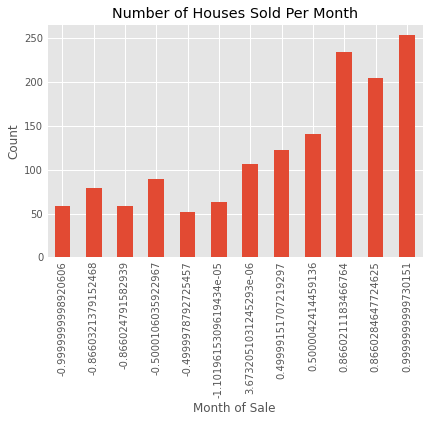

In [573]:
# When where houses sold?
train1.groupby(['MoSold']).SalePrice.count().plot(kind='bar', figsize=(6,4))
plt.title('Number of Houses Sold Per Month')
plt.ylabel("Count")
plt.xlabel("Month of Sale")
plt.show()

Not Surprisingly, market is hottest during summer. The month is indeed a period feature and I will model it by a cosine transformation. 

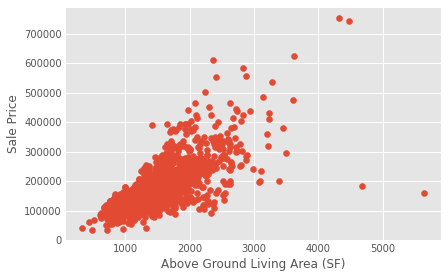

In [574]:
plt.scatter(train1['GrLivArea'], train1['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Above Ground Living Area (SF)')
plt.show()

Above Ground living area is positively correlated with price. This is intutive as people prefer more airy and 
bright above the ground areas. The next question is the price per SF.

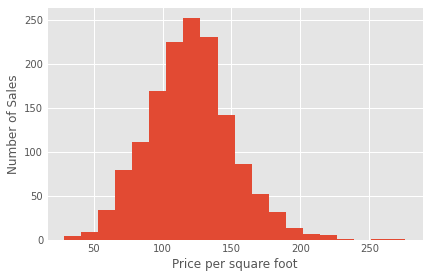

In [575]:
price_sf = train1['SalePrice']/train1['GrLivArea']
plt.hist(price_sf, bins=20)
plt.ylabel('Number of Sales')
plt.xlabel('Price per square foot')
plt.show()

In [576]:
print(price_sf.median())
print(price_sf.std())

120.09903146697134
31.391080743781764


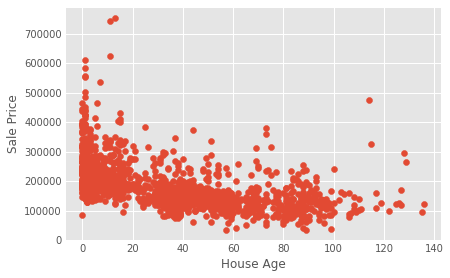

In [577]:
# Should I add a house age variable?

house_age = train['YrSold'] - train['YearBuilt']
plt.scatter(house_age, price)
plt.ylabel('Sale Price')
plt.xlabel('House Age')
plt.show()

Text(0.5, 0, 'Neighborhood')

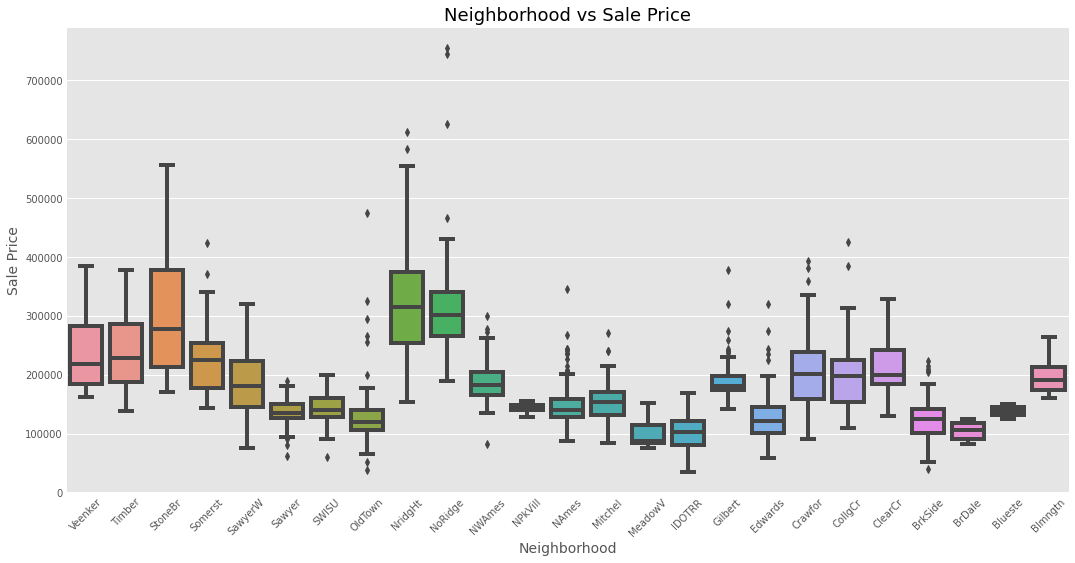

In [635]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train, x=train['Neighborhood'].sort_values(ascending=False), y=price)
plt.xticks(rotation=45);
plt.title('Neighborhood vs Sale Price', fontsize=18)
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)

## Data Cleaning & Feature Engineering

Some features have a value of NA but that doesn't mean a missing value! For example for the feature "Fence", NA 
really means that the property doesn't have a fence. We need to correct this issue. For the ease of processing we can 
first concatanate the train and test sets.

In [578]:
# Drop the duplicates
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

train.isna().sum().sum()
test.isna().sum().sum()


# Correcting the type for MSSubClass
train['MSSubClass'] = train0['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)


# Cyclical Transformation of MoSold
train["MoSold"] = -np.cos(0.5236 * train1["MoSold"])
test["MoSold"] = -np.cos(0.5236 * test["MoSold"])

In [579]:
# Change using a constant value None. For these columns NA actually means the feature 
# doesn't exist
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    train[column] = train[column].fillna("None")
    test[column] = test[column].fillna("None")

In [580]:
# Impute using the column mode

categories = [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]

for column in categories:
    train[column] = train[column].fillna(train[column].mode()[0])
    test[column] = test[column].fillna(test[column].mode()[0])

In [581]:
# Creating New Features

def feature_engineer(df):
    df['totalSqFeet'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['totalBathroom'] = df.FullBath + df.BsmtFullBath + 0.5 * (df.HalfBath + df.BsmtHalfBath)
    df['houseAge'] = df.YrSold - df.YearBuilt
    df['reModeled'] = np.where(df.YearRemodAdd == df.YearBuilt, 0, 1)
    df['isNew'] = np.where(df.YrSold == df.YearBuilt, 1, 0)
    
train_fe = train.copy() 
test_fe = test.copy()

feature_engineer(train_fe)
feature_engineer(test_fe)

In [ ]:
train.info()

In [583]:
# Create a data processing pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

numeric_transformer = Pipeline([("imputer", KNNImputer(n_neighbors=4)), 
                         ("scaler", StandardScaler())]
                       )
categorical_transformer = Pipeline(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore")), 
        ("imputer", SimpleImputer(strategy='most_frequent'))
                                       ]
                         )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)


In [622]:
train_fe.shape

(1460, 84)

## Modeling 

#### 1. Linear Model  
At ehe first step I start with a linear model, namely ridge regression and train it on "train" data meaning the data set without any feature engineering. I also don't log-scale the target value. To that end, I performed a 5-fold cross-validation on the train data and changed the regularization parameter from 0.1 (close to no regularization) all the way to 100 (strong regularization)

In [ ]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Ridge(random_state=1))]
)

param_grid = {"regressor__alpha" : [0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipe, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True);

grid_search.fit(train, price)

In [655]:
ridge_rmse_train_no_log = -grid_search.best_score_  ## the rmse is very high 

# Output: 31104.55

31104.558204213885

In [647]:
ridge_alpha_train_no_log = grid_search.best_params_

# Output: 10 

{'regressor__alpha': 10}

I learned that first of all I should try log transform on target. Second, regularization helps 
because the best value picked for alpha is apparantly much larger than 0. 

In [657]:
# log transformation of target. 

log_price = np.log(price)
grid_search.fit(train, log_price);

In [659]:
ridge_rmse_train_log = np.exp(-grid_search.best_score_)
print(f'Best RMSE: {np.exp(-grid_search.best_score_):9.5f}')

# Output: Best RMSE: 1.14943

Best RMSE:   1.14943


In [662]:
# Ridge regression on training set with extra features 

grid_search.fit(train_fe, log_price);
ridge_rmse_train_fe_log = np.exp(-grid_search.best_score_)
print(f'Best RMSE: {ridge_rmse_train_fe_log:1.5f}')

# Output: Best RMSE: 1.14908

Best RMSE: 1.14908


We see a very slight improvement when we use the training data with extra features. Let's stick with this data set from now on.

In [667]:
# convinience function to create submission files. 

def create_submission(suffix):
    price_hat = pd.DataFrame(np.exp(grid_search.predict(test_fe)))  
    price_hat["Id"] = test.index
    price_hat.columns = ["SalePrice", "Id"]
    submission = price_hat.reindex(columns=["Id", "SalePrice"])
    submission.to_csv(f"submission_{suffix}.csv", header=True, index = False)
create_submission("ridge")

### Sparsity

In [ ]:
# Let's explore wether sparsity would improve rmse 

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Lasso(random_state=1))]
)

param_grid = {"regressor__alpha" : [0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipe, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True);

grid_search.fit(train_fe, log_price)

In [676]:
lasso_rmse_train_fe_log = np.exp(-grid_search.best_score_)  ## the rmse is very high 
print(f'Best RMSE: {lasso_rmse_train_fe_log:1.5f}')
# Output: 1.23760

Best RMSE: 1.23760


The result has improved compared to ridge regression. 

In [677]:
create_submission("lasso")

In [689]:
# Let's look at the features picked by lasso.

df = pd.DataFrame(zip(train_fe.columns, 
                 list(grid_search.best_estimator_.named_steps.regressor.coef_)
                ))
df.columns = ["Feature", "Coefficient"]

df[df.Coefficient > 0]

,Feature,Coefficient
2,LotFrontage,0.134380
24,MasVnrType,0.030592
35,BsmtFinSF2,0.086787
36,BsmtUnfSF,0.028794


### Random Forest -- Dealing with non-linearity

In [690]:
# This can take about 10 minutes!

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)

param_grid = { 
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth' : [4,5,6,7,8], 
    'regressor__min_samples_split' : [2, 4, 6]
}

grid_search = GridSearchCV(clf, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True, verbose=0);

grid_search.fit(train_fe, log_price)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=4)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEF0551C90>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                           

In [694]:
rf_rmse_train_fe_log = np.exp(-grid_search.best_score_)
print(f'RMSE: {rf_rmse_train_fe_log:1.5f}')

# Output RMSE: 1.15484

RMSE: 1.15484


The score has improved compared to  both lasso and ridge regression.

In [695]:
grid_search.best_params_

{'regressor__max_depth': 8,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [642]:
print(f'RMSE: {np.exp(-grid_search.best_score_):1.5f}')

RMSE: 1.15497


In [644]:
grid_search.best_params_

{'regressor__max_depth': 8,
 'regressor__min_samples_split': 4,
 'regressor__n_estimators': 500}

In [696]:
create_submission("rf")

In [ ]:
#Kaggle Score: 0.14627

My Kaggle Score dramattically decreased from 0.25 for Ridge, to 0.21 for lasso and to 0.14 I used RF. This is indicative
of non-linearity in the data. 

In [ ]:
# This can take about 10 minutes!

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", CatBoostRegressor())]
)

param_grid = { 
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth' : [4, 6, 8]
}

grid_search = GridSearchCV(clf, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True, verbose=1);

grid_search.fit(train_fe, log_price)

In [702]:
cb_rmse_train_fe_log = np.exp(-grid_search.best_score_)
print(f'RMSE: {cb_rmse_train_fe_log:1.5f}')

RMSE: 1.12550


In [701]:
grid_search.best_params_

{'regressor__max_depth': 6, 'regressor__n_estimators': 500}

In [703]:
create_submission("cb")

In [ ]:
# Kaggle Score: 0.12556

I have to mention that this method of search is not efficient. We might want to use Bayesian Optimization libraries such as
Optuna to get even better results. 